<a href="https://colab.research.google.com/github/epi2me-labs/testbooks/blob/master/basic_qc_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Basic QC Tutorial</h1>

The Summary statistics and QC tutorial is intended as a functional guide to help assess the quality characteristics of a single Nanopore sequencing run. This tutorial aims to enable an objective assessment of the performance of a Nanopore flowcell run and to assess the sequence characteristics to benchmark quality.

Sufficient information is provided in the tutorial that the workflow can be tested, validated and replicated. The tutorial is provided with an example dataset from a barcoded sequence library. The tutorial is intended to address important questions:

* How many reads (and how many gigabases) were sequenced?
* What fraction of my sequence collection is good quality?
* How are longer sequence reads represented in my sample?

Methods used in this tutorial include:

- Python for statistical analysis and reporting, including  use of `pandas`, `numpy`, and `bokeh`, 
- the `sequencing_summary.txt` file from **MinKNOW** or **Guppy** as data source for parsing.

Computational requirements for this tutorial include:

- Computer running the **Epi2Me Labs** notebook Server
- At least 8 Gb RAM
- Runtime with provided example data - approximately 10 minutes



## Introduction

This tutorial aims to summarise the data characteristics from an Oxford Nanopore Technologies sequencing run. Observations from basecalled reads and their quality characteristics, temporal performance, and barcoded content are presented. The information presented is derived solely from the `sequence_summary.txt` file produced during basecalling with the Guppy software. 

The goals from this tutorial include:

* To introduce a literate framework for analysing base-calling summary
statistics to evaluate the relative performance of runs.
* To provide basic QC metrics so that a review and consideration of experimental data can be undertaken.
* To provide training as to which QC metrics are of most interest and to encourage an understanding of how different aspects of sequence data quality can be attributed to sample characteristics from DNA isolation and library preparation.


### The `sequencing_summary.txt` file

The `sequencing_summary.txt` file is automatically produced during base-calling with the Guppy software. This summary file contains rich metadata for each sequence read produced during a run. These data include timestamp, pore duration, read quality, and channel information, in addition to the characteristics of the resulting DNA sequence. This workflow presented here uses this summary file rather than the raw `FAST5` format data for performance reasons.

Tools such as [pomoxis](https://github.com/nanoporetech/pomoxis) utilise the fastq files for quality metrics, and other tools make extensive use of the fast5 files. Parsing the fast5 files provides additional analytical context but is much more demanding in terms of compute resource and time. This tutorial is lightweight and is intended to run within a few minutes on a desktop computer.


## Basic QC analysis and results

To start analysing our `sequencing_summary.txt` we must first "read in" the data. For this tutorial we will download a sample file of a Lambda phage sequencing run.

To download the sample file we run the `linux` command `wget`. To execute the command click on the cell and then press Command/Ctrl-Enter, or click the Play symbol to the left-hand side.

In [0]:
working_dir='basicqc_tutorial'
!mkdir -p "$working_dir"
%cd "$working_dir"
!wget -O lambda_sequencing_summary.txt.bz2 \
    https://ont-research.s3-eu-west-1.amazonaws.com/labs_resources/basicqc_tutorial/lambda_sequencing_summary.txt.bz2

If you have your own sequencing, you can edit the value of the `summary_file` variable below. To find the correct full path of a file you can navigate to it in
the `Files` browser to the left-hand side, right-click on the file and select `Copy path`:

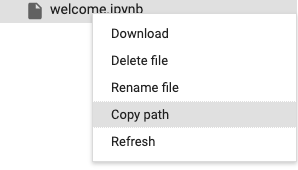

When pasting the path in the code cell you will have to remove the preceding `/` character.

The form below reads the sequencing summary file using the `pandas` library. The form can be used to enter the filename of your sequencing summary file. Alternatively you can edit the code which reads the file by first double clicking the form header. After entering your filename (or editing the code cell) remember to execute the code using `Command/Ctrl-Enter`, or pressing the `Play` symbol to the left-hand side.

> **If you want simply to plot all the graphs in this tutorial for your dataset, rather than working through the tutorial, select `Run after` from the `Runtime` menu above after entering your filepath.**

In [0]:
#@markdown Enter the path to you summary file here: (*click **here** to view code*)
# load the pandas library
import pandas as pd

# set two variables, one each for the two files
summary_file = 'lambda_sequencing_summary.txt.bz2'  #@param {type: "string"}

# Read the file, use a tab ('\t') as the separator between columns
seq_summary = pd.read_csv(summary_file, delimiter='\t')
# ensure the file is sorted by time and reset its
# indexing after doing so
seq_summary.sort_values('start_time', inplace=True)
seq_summary.reset_index(drop=True, inplace=True)

The variable `seq_summary` is now a `pandas` **dataframe** object. Having read the file we can take a peek at the start of the file using the `.head()` method of the dataframe objects:

In [0]:
# Use the .head() method one one of the dataframes
seq_summary.head()

### Numbers of reads

In order to count the number of reads sequenced in the experiment, we can
ask the dataframe how many rows it contains:



In [0]:
# Show the total number of reads
print("The total number of reads is:", len(seq_summary))

# Group the rows of the dataframe by the value of the `passes_filtering` column
# then ask the size of each group.
pass_fail = seq_summary.groupby('passes_filtering').size()

print("The number of pass reads is:", pass_fail[True])
print("The number of pass reads is:", pass_fail[False])


As a more interesting way of summarising these values we can use the `bokeh` library to create a stacked bar chart:

In [0]:
#@markdown ***Pass/Fail plot code*** (*click to show*)
# import bokeh for use
from bokeh.plotting import figure
from bokeh.models import Range1d
import bokeh.io as bkio

# Set a null y_value, we one have one factor
y_value = ['']
classes = ['Pass', 'Fail']
colors = ['darkolivegreen', 'maroon']

# describe our data
pass_percentage = 100 * pass_fail[True] / len(seq_summary)
data = {
    'y_value':y_value,
    'Pass': [pass_percentage],
    'Fail': [100 - pass_percentage]}

# create the figure
p = figure(
    title="Pass / Fail reads",
    y_range=y_value,
    plot_height=150, plot_width=600, 
    toolbar_location=None, tools="hover",
    tooltips="$name: @$name")

# plot horozontal bars
p.hbar_stack(
    classes, y='y_value',
    height=0.9, alpha=0.7,
    color=colors, source=data,
    legend_label=classes)

# hide some plotting artefacts
p.xgrid.grid_line_color = None
p.xaxis.axis_label = '%age Reads'
p.x_range = Range1d(0, 120)
p.yaxis.visible = False
# show the plot
bkio.output_notebook(hide_banner=True)
bkio.show(p)

### Read Lengths and Yield

Moving on from counting reads, let us examine the length of reads in this experiment.

We will first calculate the **mean read length** and the **N50** read length:

In [0]:
# take the `sequence_length_template` column (the read lengths)
# and sort them in ascending order
sorted_lengths = seq_summary.sequence_length_template.sort_values(ascending=False).reset_index(drop=True)
# calculate the cumulative sum of lengths
cumulative_length = sorted_lengths.cumsum()
# find the total number of bases and the mean length
total_bases = cumulative_length.iloc[-1]
mean_length = total_bases / len(seq_summary)
# find the N50 length: the length for which half the reads are longer
n50_index = cumulative_length.searchsorted(total_bases / 2)
n50_length = sorted_lengths.iloc[n50_index]

These values be will used below to annotate the plots. We can depict the read length distribution is several way. The simplest is as a simple histogram:

In [0]:
#@markdown ***Length distribution code*** (*click to show*)
# calculate counts for a histogram using numpy
import numpy as np
counts, edges = np.histogram(
    seq_summary.sequence_length_template,
    bins=400)

# create a figure
p = figure(
    title='Read length distribution',
    output_backend="webgl",
    height=300, width=600)

# plot the bars
p.quad(top=counts, bottom=0, left=edges[:-1], right=edges[1:],
    fill_color='blue', line_color=None, alpha=0.6)

# plot a vertical line for mean and N50 read length
line_types = (('Mean', mean_length), ('N50', n50_length))
for name, val in line_types:
    p.line(
        x=[val, val], y=[0, 0.8*max(counts)],
        line_width=1.5, color='black')
    p.text(x=[val], y=[0.8*max(counts)],
        text=['{}: {:.0f}'.format(name, val)])

# limit the display range
p.x_range = Range1d(start=0, end=55e3, bounds=(0, None))
p.y_range = Range1d(start=0, end=1.1*max(counts), bounds=(0, None))
# add axis labels
p.xaxis.axis_label = 'Read Length / bases'
p.yaxis.axis_label = 'Number of reads'
# show the plot
bkio.output_notebook(hide_banner=True)
bkio.show(p)

> The distribution of sequence lengths will be dependent on the protocols that have been used to extract and/or prepare the starting DNA. Sequences from amplicon DNA will have a tight distribution of read lengths, while sequences from genomic DNA will have a broader distribution. The distribution will be further influenced if a size-selection step has been used, and will also be dependent on the choice of sequencing library preparation kits. The read-length distribution should be assessed to see if the distribution is concordant with that expected.

In the above graph we observe a spread of read lengths with a strong peak in the distribution at around **48 kbases**, the length of the genome under examination. 

A second way to visualise the read length distribution is as a mass distribution, or a weighted histogram. This method most similarly portrays the intensities that would be seen in an electrophoresis experiment.

In [0]:
#@markdown ***Length mass dist. code*** (*click to show*)
# Compute weighted histogram with numpy.
counts, edges = np.histogram(
    seq_summary.sequence_length_template,
    weights=seq_summary.sequence_length_template,
    bins=400)

# All similar to the above
p = figure(
    title='Read length distribution',
    output_backend="webgl",
    height=300, width=600)

p.quad(
    top=counts / sum(counts), bottom=0,
    left=edges[:-1], right=edges[1:],
    fill_color='blue', line_color=None, alpha=0.6)
p.x_range = Range1d(
    start=0, end=55e3, bounds=(0, None))
p.y_range = Range1d(
    start=0, end=1.1*max(counts)/sum(counts),
    bounds=(0, None))
p.xaxis.axis_label = 'Read Length / bases'
p.yaxis.axis_label = 'Base density'
# show the plot
bkio.output_notebook(hide_banner=True)
bkio.show(p)


***Note how a normalised density has been plotted, to avoid misinterpretation when plotting simply the total bases per bin.***

> The weighted read length histogram above shows the binned distribution of sequence length against number of sequence nucleotides contained within the bin. This plot will show clear peaks if for example, amplicons are sequenced or if size selection has been performed.



A final way of viewing this data is to take the cumulative sum of the number of bases and plot it against the read lengths, to obtain a curve expressing the number of bases contained within reads above a given length:

In [0]:
#@markdown ***Yield plot code*** (*click to show*)
# Create a simple line graph
p = figure(
    title='Base yield above given read length',
    output_backend="webgl",
    height=300, width=600)

# The `[0:-1:10000]` removes points to make plotting faster
p.line(
    x=sorted_lengths[0:-1:10000],
    y=cumulative_length[0:-1:10000] / 1e9,
    line_width=1.5)

# set up axes as usual
p.x_range = Range1d(
    start=0, end=55e3, bounds=(0, None))
p.y_range = Range1d(
    start=0, end=1.1*max(cumulative_length)/1e9,
    bounds=(0, None))
p.xaxis.axis_label = 'Read Length / bases'
p.yaxis.axis_label = 'Yield above length / Gbases'
# show the plot
bkio.output_notebook(hide_banner=True)
bkio.show(p)


This graph indicates how many small fragments contribute equally to the total yield as fewer longer fragments.

From the graph we can read off that the total yield of the experiment was around 13.5 Gbases.

### Quality Scores

In this section we will review the predicted quality of the sequencing
data using the mean per-base quality score of reads written in the `sequencing_summary.txt` file.

Let's start by simply plotting a histogram of the quality scores:

In [0]:
#@markdown ***Quality Plot*** (*click to show*)
# create a figure as usual
p = figure(
    title='Read Qualities', output_backend="webgl",
    height=300, width=600)

# for both `Pass` and `Fail` reads plot a histogram
max_count = 0
for status in [True, False]:
    data = seq_summary[seq_summary['passes_filtering'] == status]
    counts, edges = np.histogram(
        data.mean_qscore_template,
        bins=100)
    p.quad(
        top=counts / 1e6, bottom=0,
        left=edges[:-1], right=edges[1:],
        fill_color=['maroon', 'darkolivegreen'][status],
        line_color=None, alpha=0.7,
        legend_label=['Fail', 'Pass'][status])
    max_count = max(max_count, max(counts))
    
# set up axes
p.legend.location = 'top_left'
p.x_range = Range1d(start=1, end=14, bounds=(0, None))
p.y_range = Range1d(start=0, end=max_count/1e6, bounds=(0, None))
p.xaxis.axis_label = 'Read Quality Score'
p.yaxis.axis_label = 'Count reads / M'
# show the plot
bkio.output_notebook(hide_banner=True)
bkio.show(p)

> The read quality score is calculated as the mean of the per-base quality scores of a read. Each per base quality gives an estimation of the error of that base in expressed on a logarithmic scale: $QV = -10\log_{10} (P_{error})$).

Evident from the histogram above is the threshold value for determining the `Pass` of `Fail` status of reads. The boundary is chosen to be in the tail of the distribution. This QV filter is applied during the base-calling process as a modifiable parameter. For downstream analyses we recommend processing only the higher-quality sequence reads.

## Performance through time

A key metric in the quality review of a sequencing run is an analysis of the temporal performance of the run. During a run each sequencing channel will address a selection of different pores and the individual pores may become temporarily or permanently blocked. It is therefore expected that during a run sequencing productivity will decrease. It is useful to consider whether the observed productivity decline is normal or if it happens more rapidly than expected. A rapid pore decline could be indicative of contaminants with the sequencing library.

### Throughput

Plotting the number of bases generated per unit time over the course of a sequencing run can reveal unexpected behaviours. In an ideal experiment there should not be any sudden decreases in performance.

In [0]:
#@markdown ***Thoughput plot code*** (*click to show*)
# calculate a start time for each read rounded to 5 minutes

#@markdown Numbers of minutes by which to discretize time:
discretize =   10#@param {type:"integer"}

seq_summary['time'] = (seq_summary['start_time'] / 60 / discretize).astype(int)
# group the data by quarter hour and pass/fail
groups = seq_summary.groupby(['passes_filtering', 'time'], as_index=False)
# sum the bases per group
throughput = groups['sequence_length_template'].agg('sum')

# create a plot
p = figure(
    title='Base Throughput', output_backend="webgl",
    height=300, width=600)

tp = throughput  # save some typing
max_time = 0
max_tp = 0
# draw a line for each class as Mbases per minute
for status in (True, False):
    data = tp[tp.passes_filtering == status]
    p.line(
        x=data.time / (60 / discretize),
        y=data.sequence_length_template / discretize / 1e6,
        color=['maroon', 'darkolivegreen'][status],
        legend_label=['Fail', 'Pass'][status],
        line_width=1.5)
    max_time = max(max_time, max(data.time) / (60 / discretize))
    max_tp = max(max_tp, max(data.sequence_length_template))

# set up the axes
p.x_range = Range1d(
    start=0, end=1.1*max_time,
    bounds=(0, None))
p.y_range = Range1d(
    start=0, end=1.1*max_tp / discretize / 1e6,
    bounds=(0, None))
p.xaxis.axis_label = 'time / hr'
p.yaxis.axis_label = 'Throughput / (Mbases / min)'
# show the plot
bkio.output_notebook(hide_banner=True)
bkio.show(p)


The above plot shows a steady decline in the sequencing rate for `Pass` reads, with a constant background of `Fail` reads. The dips in throughput every hour are normal as the sequencing control software **MinKNOW** reassessed from which pores to record data.

A second way of viewing the sequencing throuhput is to plot the cumulative yield through time.

In [0]:
#@markdown ***Base yield plot code*** (*click to show*)
# group the data by pass/fail
groups = seq_summary.set_index(['passes_filtering']).groupby(level=0, as_index=False)
# calculate a cumulative sum of the number of bases sequenced (per group)
sum_tp = groups['sequence_length_template'].cumsum().reset_index()
# attach the start times from the original table
sum_tp['start_time'] = seq_summary['start_time']

# create a plot
p = figure(
    title='Base Yield', output_backend="webgl",
    height=300, width=600)

max_time = 0
max_tp = 0
# draw a line for each class
for status in (True, False):
    data = sum_tp[sum_tp.passes_filtering == status]
    # take a selection of rows to speed plotting
    data = data[0:-1:10000]
    p.line(
        x=data.start_time / 3600,
        y=data.sequence_length_template / 1e9,
        color=['maroon', 'darkolivegreen'][status],
        legend_label=['Fail', 'Pass'][status],
        line_width=1.5)
    max_time = max(max_time, max(data.start_time) / 3600)
    max_tp = max(max_tp, max(data.sequence_length_template))

# set up the axes
p.legend.location = 'top_left'
p.x_range = Range1d(
    start=0, end=1.1*max_time,
    bounds=(0, None))
p.y_range = Range1d(
    start=0, end=1.1*max_tp / 1e9,
    bounds=(0, None))
p.xaxis.axis_label = 'time / hr'
p.yaxis.axis_label = 'yield / Gbases'
# show the plot
bkio.output_notebook(hide_banner=True)
bkio.show(p)

### Sequencing speed

As well as changed in throughput over time another diagnostic metric to evaluate is the sequencing speed: the number of bases processed per second by the enzymes controlling the movement of DNA through the nanopore channels.

In [0]:
#@markdown ***Sequencing speed plot code*** (*click to show*)
# Create a new data frame with time (in hours) and sequencing speed
# for each read
df = pd.DataFrame(dict(
    hour=(seq_summary.start_time / 3600).astype(int),
    speed=seq_summary.sequence_length_template / seq_summary.duration
))
hours = df.hour.unique()

# find the quartiles and IQR for each category
groups = df.groupby('hour')
q1 = groups.quantile(q=0.25)
q2 = groups.quantile(q=0.5)
q3 = groups.quantile(q=0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr

# create a plot
p = figure(
    title='Sequencing speed', output_backend="webgl",
    height=300, width=600)

# stems
p.segment(hours, upper.speed, hours, q3.speed, line_color="black")
p.segment(hours, lower.speed, hours, q1.speed, line_color="black")

# boxes
for low, high in ((q2.speed, q3.speed), (q1.speed, q2.speed)):
    p.vbar(
        hours, 0.8, low, high,
        fill_color="blue", alpha=0.7,
        line_color="black")

# set up the axes
p.x_range = Range1d(
    start=0, end=1.1*max(hours),
    bounds=(0, None))
p.y_range = Range1d(
    start=0, end=1.1*max(upper.speed),
    bounds=(0, None))
p.xaxis.axis_label = 'time / hr'
p.yaxis.axis_label = 'speed / (bases / s)'
# show the plot
bkio.output_notebook(hide_banner=True)
bkio.show(p)

### Active Channels

The graphs above all depict the changing rate of sequencing from the perspective of the volume of data produced. A contribution to the falling sequencing rate is the number of functional channels falls throughout the experiment.

A channel is defined as being active if one or more sequence reads are observed per time window. It is expected that over the course of the run pores will block and the number of channels producing data will decrease. Changing the pore used by the channel and strategies to unblock pores mean that the number of functional channels may increase or decrease at a given timepoint but generally the number of channels producing data will decrease over time.


In [0]:
#@markdown ***Active channels plot code*** (*click to show*)

#@markdown Numbers of minutes by which to discretize time:
discretize =   5#@param {type:"integer"}

# calculate a start time for each read rounded to discretize minutes
seq_summary['time'] = (seq_summary['start_time'] / 60 / discretize).astype(int)
# group the data by quarter hour
groups = seq_summary.groupby('time', as_index=False)
# count the unique channels in each 5 minutes
chan_counts = groups['channel'].apply(lambda x: len(x.unique()))
hours = chan_counts.index / (60 / discretize)

# create a plot
p = figure(
    title='Functional channels ({}min period)'.format(discretize),
    output_backend="webgl",
    height=300, width=600)

p.line(
    x=hours,
    y=chan_counts,
    line_width=1.5)

# set up the axes
p.x_range = Range1d(
    start=0, end=1.1*max(hours),
    bounds=(0, None))
p.y_range = Range1d(
    start=0, end=1.1*max(chan_counts),
    bounds=(0, None))
p.xaxis.axis_label = 'time / hr'
p.yaxis.axis_label = 'active channels'
# show the plot
bkio.output_notebook(hide_banner=True)
bkio.show(p)


## Sequencing channel activity plot

The nanopores through which DNA is passed, and signal collected, are arrayed as a 2-dimensional matrix. A heatmap can be plotted showing channel productivity against spatial position on the matrix. Such a plot enables the identification of spatial artifacts that could result from membrane damage through e.g. the introduction of an air-bubble. This heatmap representation of spatial activity shows only gross spatial aberations. Since each channel can address four differemnt pores (Mux) the activity plot below shows the number of sequences produced per channel, not per pore.

**Counting reads and channel map**

We will break apart displaying the channel activity into two steps since the code is quite long. First we count form our dataset; for this we need to calculate the positions of channels in the flowcell:


In [0]:
#@markdown ***Code for calculating position of channels on flowcells***
def minion_array():
    # The array is composed of blocks of 64 channels, the low
    # halve is to the right (high to left), working inwards
    # in a 4 x 8 block
    def channel_block(i):
        m = np.zeros((4, 16), dtype=int)
        m[4::-1, :7:-1] = np.arange(i, i+32).reshape(4, 8)
        m[4::-1, 0:8] = np.arange(i + 32, i + 64).reshape(4, 8)
        return m
    # the blocks ascend from high to low, except the
    # lowest block is at the top
    first_channel = list(range(65, 450, 64)) + [1]
    channel_array = np.vstack([channel_block(x) for x in first_channel])
    ca = pd.DataFrame(channel_array).reset_index().melt('index')
    ca.columns = ['row', 'column', 'channel']
    return ca

channel_maps = {
    'minion':minion_array(),
    # TODO: add PromION and Flongle
    }


Using the channel map from the above code cell we can create a table with columns `row`, `column`, and `reads`:

In [0]:
channel_map = channel_maps['minion']

# count pass reads per channel...
counts = seq_summary[seq_summary['passes_filtering']] \
    .groupby('channel') \
    .size().to_frame('reads') \
    .reset_index()
# ...and merge with the channel map
counts = counts.merge(channel_map, on='channel', how='outer').fillna(0)

Now that we have out counts, we can plot a heat map:

In [0]:
#@markdown ***Activity heat-map plot code*** (*click to show*)
from bokeh.models import LinearColorMapper, ColorBar
from bokeh.palettes import Blues9

# create a figure
p = figure(
    title="Channel Activity",
    plot_height=300, plot_width=600)

# define a colour map
colors = Blues9[::-1]
mapper = LinearColorMapper(
    palette=colors,
    low=min(counts['reads']),
    high=max(counts['reads']))

# plot heatmap rectangles
p.rect(
    source=counts, x="column", y="row",
    width=1, height=1,
    fill_color={'field':'reads', 'transform':mapper},
    line_color=None)

# add colour scale
color_bar = ColorBar(
    title="# reads", color_mapper=mapper, label_standoff=10,
    location=(0, 0))
p.add_layout(color_bar, 'right')

# hide some plotting artefacts
p.x_range.range_padding = 0
p.y_range.range_padding = 0
p.xaxis.visible = False
p.yaxis.visible = False
# set up the axes
xmin, xmax = -0.5, max(counts.column)+ 0.5
p.x_range = Range1d(
    start=xmin, end=xmax,
    bounds=(xmin, xmax))
ymin, ymax = -0.5, max(counts.row)+ 0.5
p.y_range = Range1d(
    start=ymin, end=ymax,
    bounds=(ymin, ymax))
# show plot
bkio.output_notebook(hide_banner=True)
bkio.show(p)

## Summary

This tutorial has stepped through basic QC analysis of a Nanopore sequencing run. The sequencing throughout and read lengths have been explored, as has the progression of the experiment through the course of time.

The analysis presented can be run on any `sequencing_summary.txt` from **MinKNOW** or **Guppy**. The code will run within **Google Colab** when connected to a local **Epi2Me Labs** notebook server.

[Back to Epi2Me Labs](https://colab.research.google.com/github/epi2me-labs/resources/blob/master/welcome.ipynb)
